## 進階機器學習 HW4-1
#### Utilize the CLIP model to perform image classification on the dataset provided in `HW2_MNIST_train.zip`. Evaluate and report the Top-1 and Top-3 classification accuracy.
* 學號: B103040047
* 姓名: 周安

[Reference of this colab notebooks](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)

[openai/CLIP](https://github.com/openai/CLIP)



## Use `CLIP` model, `ViT-L/14@336px`, to do **zero-shot** prediction.
## Use `predict_2` to do inference.
* input text is like **'a photo of the number: "0".'**

## HW4-1 Final Result:
* Top-1 Accuracy: 76.3440%
* Top-3 Accuracy: 88.0067%

Unzip the dataset

In [21]:
# !mkdir -p HW2_MNIST_train
# !unzip HW2_MNIST_train.zip -d HW2_MNIST_train

In [22]:
# !ls HW2_MNIST_train | wc

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [23]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [24]:
import numpy as np
import torch
from pkg_resources import packaging
import os
print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu124


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [25]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
model, preprocess = clip.load("ViT-L/14@336px", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


# Image Preprocessing

1. We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

2. I add my own transform ehich can move the digits to the center of the images.

3. **Use `torchvision.io.read_image` to read the image first; then, do `2.` and then do `1.`.**


In [28]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7bb5fa4a7d80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [29]:
import cv2
import torchvision.transforms as transforms

IMAGE_SIZE = 32  # Target image size after this transform preprocessing

# Load MNIST image and preprocess it
def preprocess_mnist_cv2(image_tensor):
    """
    Preprocess MNIST images by locating the digit, centering it, and resizing.
    Args:
        image_tensor (torch.Tensor): Input tensor of shape (1, 128, 128).
    Returns:
        PIL.Image (RGB): Processed image with digit centered and resized.
    """
    # Convert tensor to NumPy array
    img = image_tensor.numpy().squeeze(0)  # Shape: (128, 128)

    # Normalize pixel values to 0-255 (convert from range 0-1 if needed)
    img = (img * 255).astype(np.uint8)

    # Apply thresholding to segment the digit, turn digit into 255 and background into 0
    _, binary_img = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)

    # Find contours (detecting digit boundary)
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return Image.fromarray(img).convert("RGB")  # If no contours found, return original image

    # Get bounding box of the detected digit
    x, y, w, h = cv2.boundingRect(contours[0])


    # prevent it detect wrong area like a dot
    if w*h < 50:
        return Image.fromarray(img).convert("RGB")
    # Crop the digit
    digit_roi = img[y:y+h, x:x+w]

    # Ensure the bounding box fits within IMAGE_SIZE. If not, use larger temp image size first, and it will be resized at next step in transform
    # May increase the ratio of the digit in the image
    if w > IMAGE_SIZE or h > IMAGE_SIZE:
        temp_image_size = np.max([w, h])
        # This cropped image would be temp_image_size*temp_image_size temporarily
        # Compute padding sizes to center the digit
        top_padding = (temp_image_size - h) // 2
        bottom_padding = temp_image_size - h - top_padding
        left_padding = (temp_image_size - w) // 2
        right_padding = temp_image_size - w - left_padding
        # Pad with black pixels (value=0) to center the digit in IMAGE_SIZE x IMAGE_SIZE
        digit_padded = cv2.copyMakeBorder(digit_roi, top_padding, bottom_padding,
                                      left_padding, right_padding,
                                      cv2.BORDER_CONSTANT, value=0)

        return Image.fromarray(digit_padded).convert("RGB")  # Skip cropping if digit is too large
    else:
        # Compute padding sizes to center the digit
        top_padding = (IMAGE_SIZE - h) // 2
        bottom_padding = IMAGE_SIZE - h - top_padding
        left_padding = (IMAGE_SIZE - w) // 2
        right_padding = IMAGE_SIZE - w - left_padding

        # Pad with black pixels (value=0) to center the digit in IMAGE_SIZE x IMAGE_SIZE
        digit_padded = cv2.copyMakeBorder(digit_roi, top_padding, bottom_padding,
                                        left_padding, right_padding,
                                        cv2.BORDER_CONSTANT, value=0)
        # Convert back to PIL image
        return Image.fromarray(digit_padded).convert("RGB")

# Define image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3-channel image
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),  # Standardize input size before processing
    transforms.ToTensor(),  # Convert back to tensor (normalized)

    transforms.Lambda(preprocess_mnist_cv2),  # Center digit and resize, return PIL image
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Make sure it is resize into target size if it didn't resize at last step
    # Return PIL image and preprocess will accept it
])

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [30]:
test = clip.tokenize('a photo of the number: "7".')
print(test.shape)
print(test)

torch.Size([1, 77])
tensor([[49406,   320,  1125,   539,   518,  2842,   281,   257,   278,  2811,
         49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [31]:
# first create text label
# pre_string = "This is a photo of number "
# pre_string = 'a photo of the number: "7".'
# labels = ["zero", "one", 'two', 'three', "four", "five", "six", "seven", "eight", "nine"]
labels = [f'a photo of the number: "{i}".' for i in range(10)]
# labels = [pre_string + i for i in labels]
print(labels)
# labels_num = list(range(0,10))
# labels_num = list(map(str, labels_num))
# labels_num = [pre_string + i for i in labels_num]
# print(labels_num)

['a photo of the number: "0".', 'a photo of the number: "1".', 'a photo of the number: "2".', 'a photo of the number: "3".', 'a photo of the number: "4".', 'a photo of the number: "5".', 'a photo of the number: "6".', 'a photo of the number: "7".', 'a photo of the number: "8".', 'a photo of the number: "9".']


In [32]:
# dir name
MNIST_TRAIN_DIR = "HW2_MNIST_train"
# prepare the filename and description
mnist_dataset = dict()
for fname in [filename for filename in os.listdir(MNIST_TRAIN_DIR) if filename.endswith(".png") or filename.endswith(".jpg")]:
  txt_fname = fname.split(".")[0] + ".txt"
  txt_path = os.path.join(MNIST_TRAIN_DIR, txt_fname)
  fpath = os.path.join(MNIST_TRAIN_DIR, fname)
  # Open the file and read the line
  with open(txt_path, "r") as file:
    line = file.readline().strip()  # Read the first line and remove whitespace

  # Split the values by tab (\t) or space
  label = list(map(int, line.split()[0]))[0]  # Convert each to int
  mnist_dataset[fpath] = label

print(f"File number in {MNIST_TRAIN_DIR}: {len(mnist_dataset)}")

File number in HW2_MNIST_train: 97396


In [33]:
count = 0
for key, value in mnist_dataset.items():
  print(key, value)
  count += 1
  if count == 10:
    break

HW2_MNIST_train/0025626.png 1
HW2_MNIST_train/0039202.png 3
HW2_MNIST_train/0010295.png 0
HW2_MNIST_train/0027108.png 2
HW2_MNIST_train/0103392.png 8
HW2_MNIST_train/0084618.png 6
HW2_MNIST_train/0014507.png 1
HW2_MNIST_train/0111151.png 9
HW2_MNIST_train/0023623.png 1
HW2_MNIST_train/0085297.png 6


In [34]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
import torchvision

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Test if proprocessing  works.

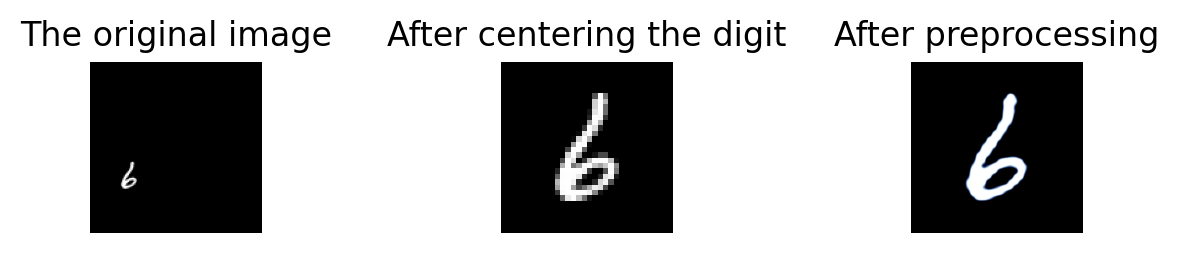

In [36]:
image_path = list(mnist_dataset.keys())[678]
image = Image.open(image_path)
plt.subplot(1, 5, 1)
plt.title("The original image")
plt.imshow(image.convert("RGB"))
plt.axis("off")

image = torchvision.io.read_image(image_path)
trans_image = transform(image)
plt.subplot(1, 5, 3)
plt.title("After centering the digit")
plt.imshow(trans_image)
plt.axis("off")

prepro_image = preprocess(trans_image)
plt.subplot(1, 5, 5)
plt.title("After preprocessing")
plt.axis("off")
plt.imshow(prepro_image.permute(1,2,0))

### Show some images aftter preprocessing

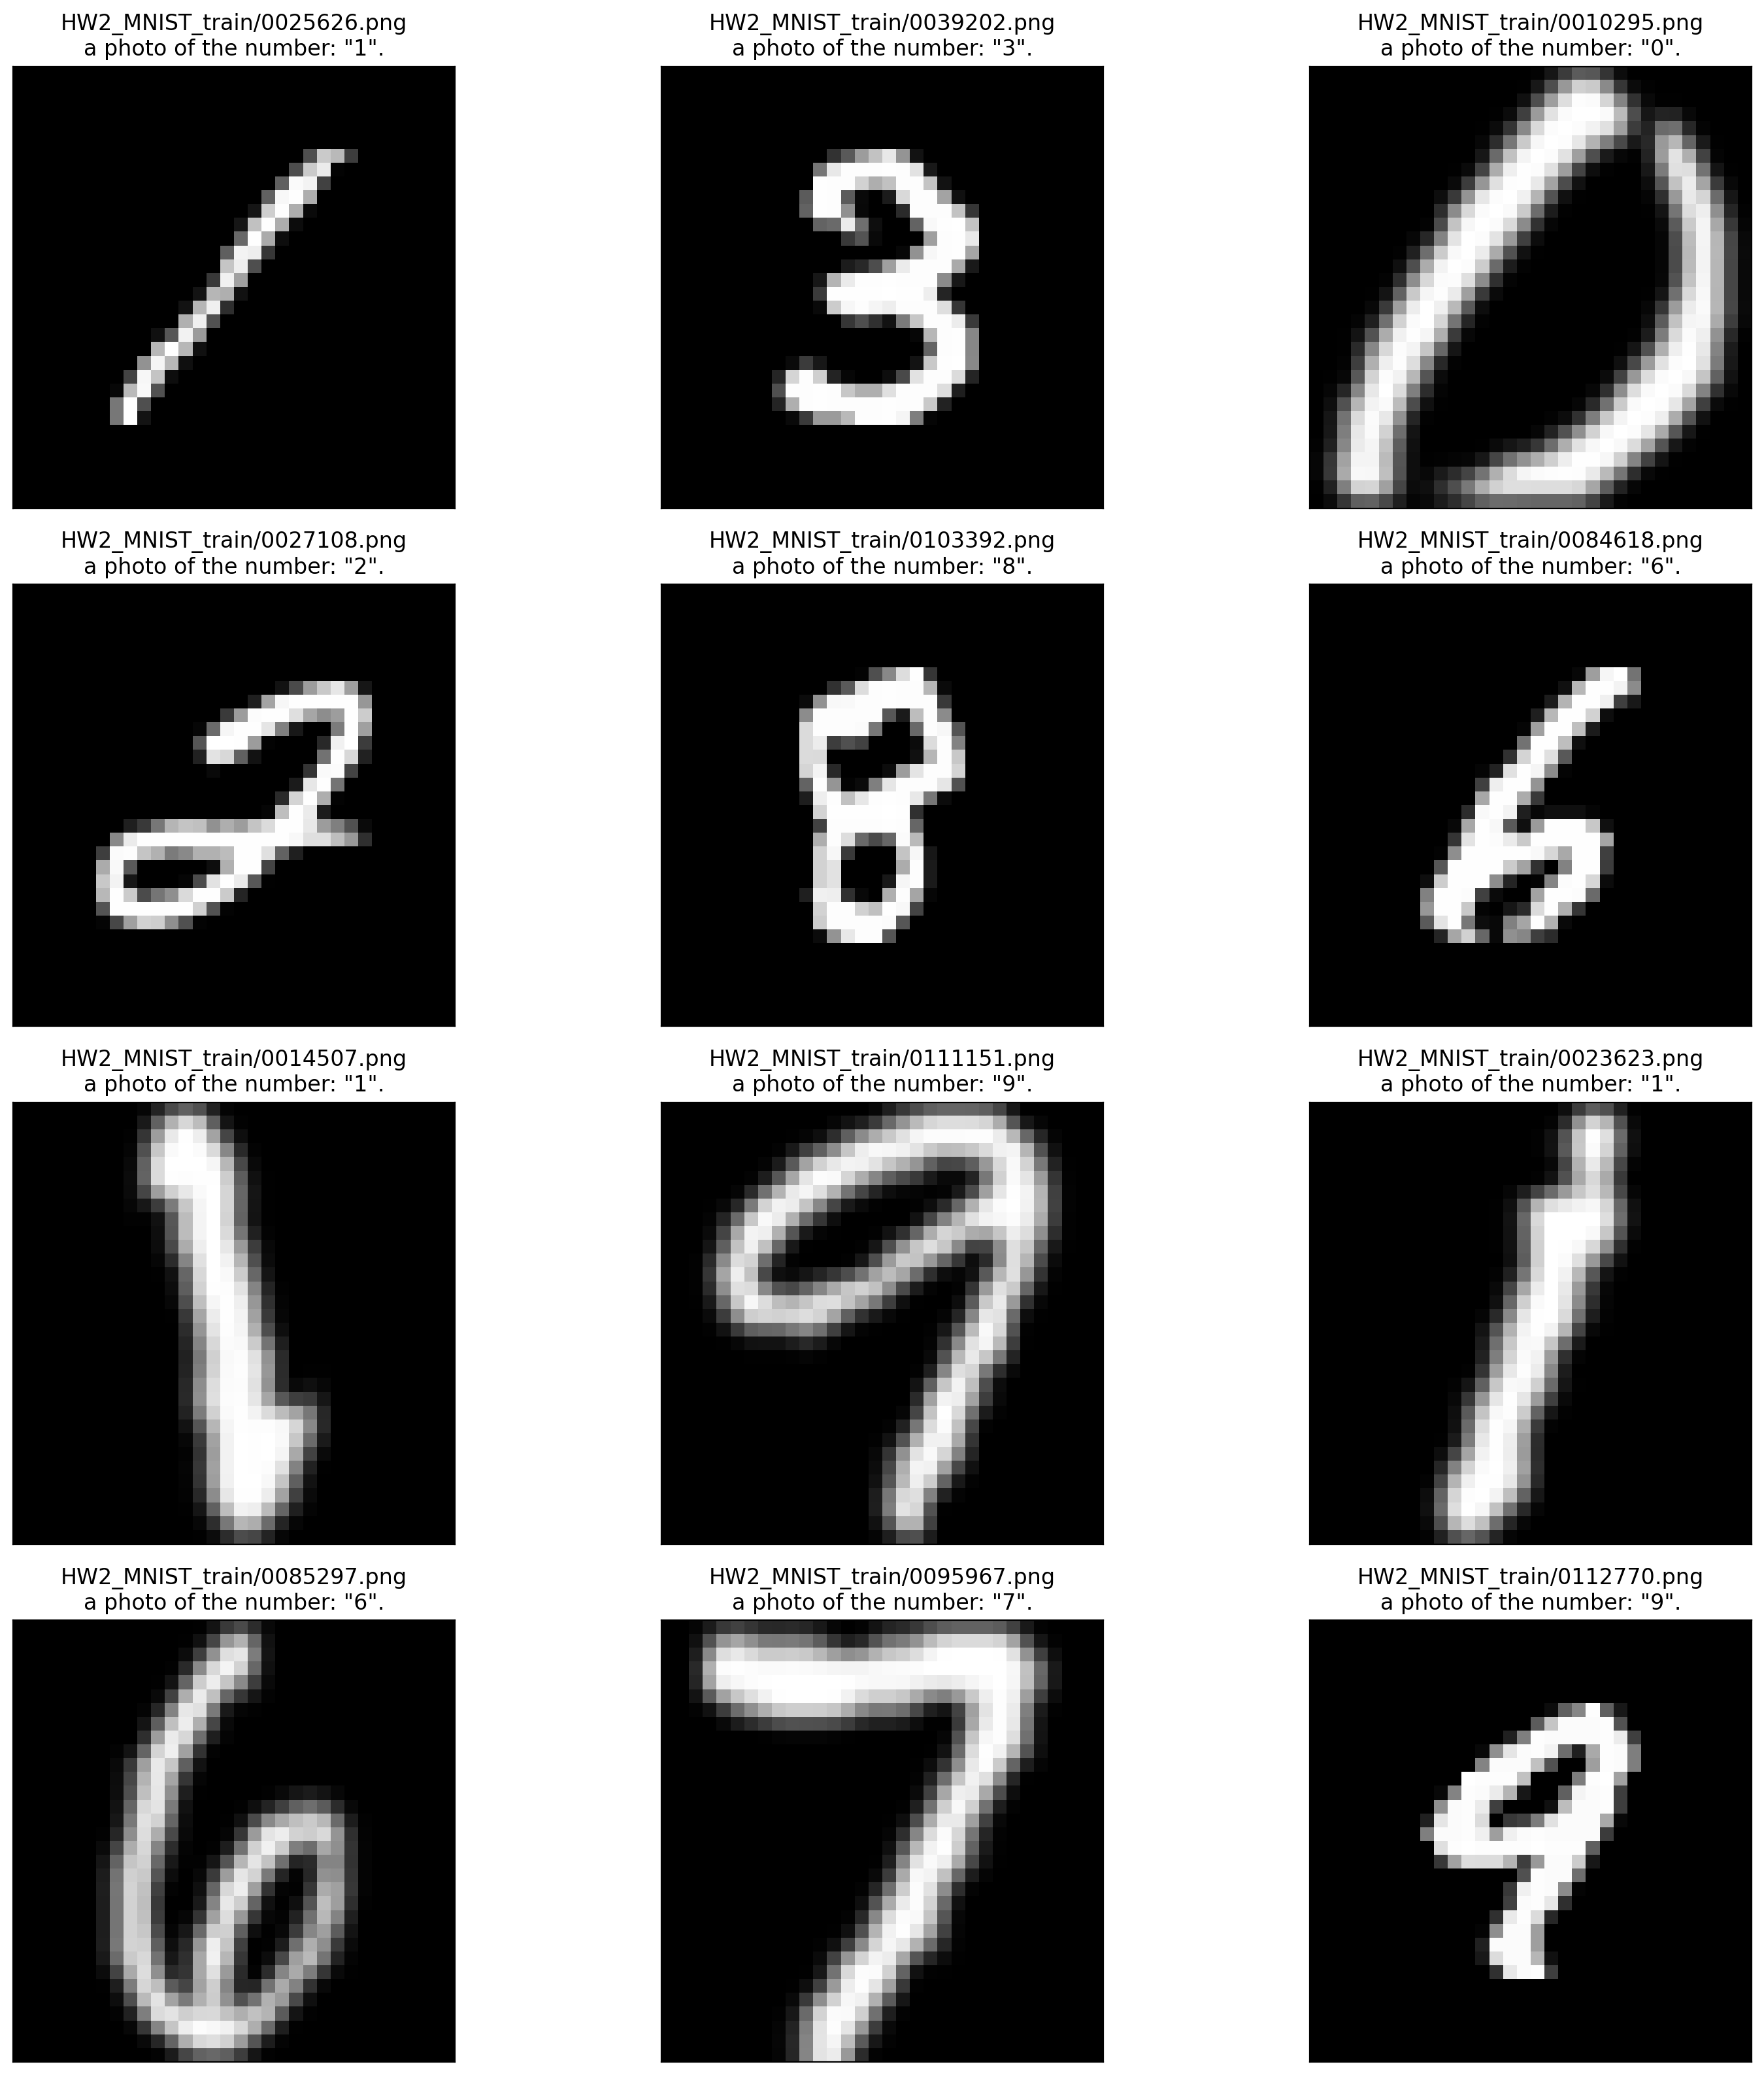

In [37]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 16))

count = 0
for filename, label in mnist_dataset.items():

  image = torchvision.io.read_image(filename)
  preprocessed_image = preprocess(transform(image))
  plt.subplot(4, 3, len(images) + 1)
  plt.imshow(transform(image))
  plt.title(f"{filename}\n{labels[label]}")
  plt.xticks([])
  plt.yticks([])

  original_images.append(transform(image))
  images.append(preprocessed_image)
  texts.append(labels[label])

  count += 1
  if count == 12:
    break
plt.tight_layout()

In [38]:
# see how many input image
print("Number of input image:", len(images))
# see the preprocessed image
print(images[0].shape)

Number of input image: 12
torch.Size([3, 336, 336])


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [39]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize([desc for desc in texts]).cuda()

In [40]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [41]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

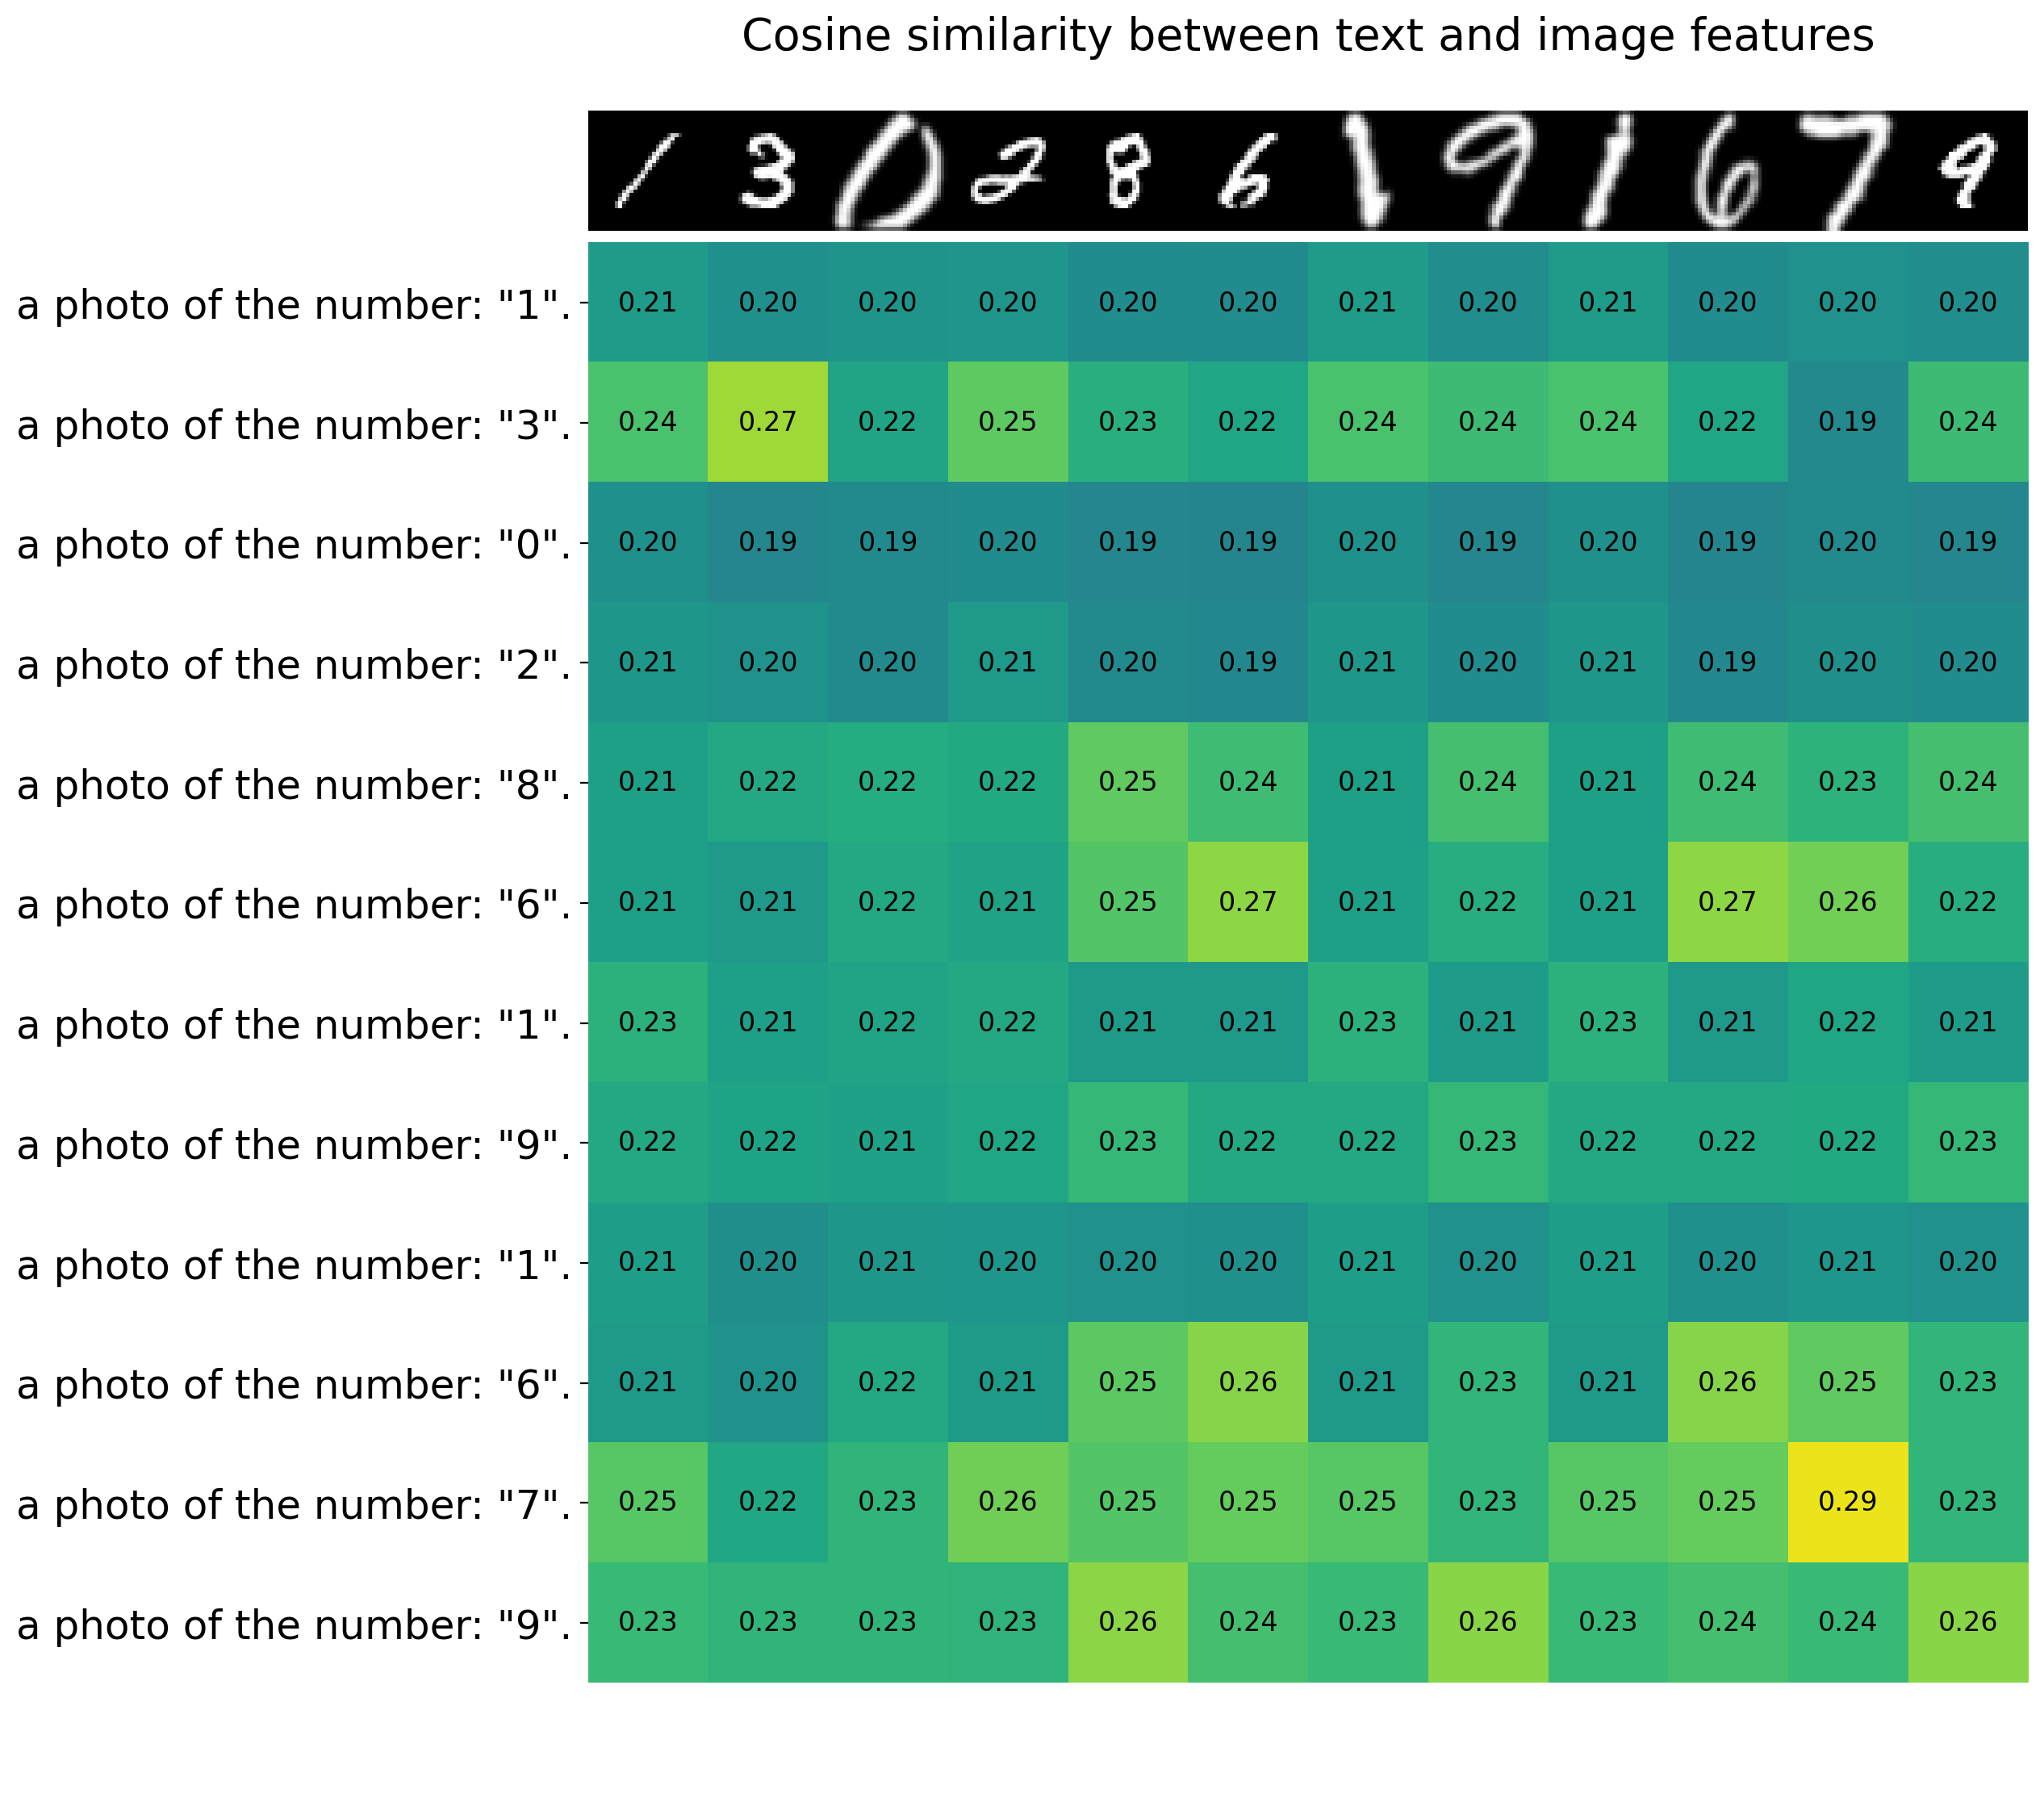

In [42]:
count = len(images)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Test on predict one image.
### There is two types inferences:
1. Use `model` forward function defined in CLIP.
2. Encode the image and text, and then do dot.
* **Two results sometimes are different!!**

#### 1. Use model(image, text)

In [43]:
idx = 3456
image_path = list(mnist_dataset.keys())[idx]
label = mnist_dataset[image_path]

image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device) # add batch size
text = clip.tokenize(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu()[0]
    values, indices = probs.topk(3)
print("Label probs:\n", probs)
print(f"Ground truth: {label}")
print("Top predictions:")
for value, index in zip(values, indices):
    print(f"\t{labels[index]:<25}: {100 * value.item():.2f}%")

Label probs:
 tensor([4.7989e-03, 7.2060e-03, 1.5251e-02, 3.1161e-04, 5.6114e-03, 1.7118e-03,
        1.7288e-02, 9.4385e-01, 3.5114e-03, 5.1403e-04], dtype=torch.float16)
Ground truth: 7
Top predictions:
	a photo of the number: "7".: 94.38%
	a photo of the number: "6".: 1.73%
	a photo of the number: "2".: 1.53%


In [44]:
idx = 111
image_path = list(mnist_dataset.keys())[idx]
label = mnist_dataset[image_path]

image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device) # add batch size
text = clip.tokenize(labels).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu()[0]
    values, indices = probs.topk(3)
print("Label probs:\n", probs)
print(f"Ground truth: {label}")
print("Top predictions:")
for value, index in zip(values, indices):
    print(f"\t{labels[index]:<25}: {100 * value.item():.2f}%")

Label probs:
 tensor([0.0364, 0.0490, 0.0419, 0.1020, 0.0846, 0.3047, 0.2372, 0.0406, 0.0669,
        0.0370], dtype=torch.float16)
Ground truth: 5
Top predictions:
	a photo of the number: "5".: 30.47%
	a photo of the number: "6".: 23.72%
	a photo of the number: "3".: 10.20%


#### 2. Do it manually.

In [45]:
idx = 3456
image_path = list(mnist_dataset.keys())[idx]
label = mnist_dataset[image_path]

# Load and convert to RGB
image = torchvision.io.read_image(image_path)
image_input = preprocess(transform(image)).unsqueeze(0).to(device)

# Tokenize labels
text_inputs = clip.tokenize(labels).to(device)

# Encode
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Normalize and compare
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Output
values, indices = similarity[0].topk(3)
print(f"Ground truth: {label}")
print("Top predictions:")
for value, index in zip(values, indices):
    print(f"\t{labels[index]:<25}: {100 * value.item():.2f}%")


Ground truth: 7
Top predictions:
	a photo of the number: "7".: 93.75%
	a photo of the number: "2".: 1.80%
	a photo of the number: "6".: 1.66%


In [46]:
idx = 111
image_path = list(mnist_dataset.keys())[idx]
label = mnist_dataset[image_path]

# Load and convert to RGB
image = torchvision.io.read_image(image_path)
image_input = preprocess(transform(image)).unsqueeze(0).to(device)

# Tokenize labels
text_inputs = clip.tokenize(labels).to(device)

# Encode
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Normalize and compare
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Output
values, indices = similarity[0].topk(3)
print(f"Ground truth: {label}")
print("Top predictions:")
for value, index in zip(values, indices):
    print(f"\t{labels[index]:<25}: {100 * value.item():.2f}%")


Ground truth: 5
Top predictions:
	a photo of the number: "5".: 54.74%
	a photo of the number: "6".: 28.83%
	a photo of the number: "4".: 7.88%


# Zero-Shot Image Classification

You can classify images using the **cosine similarity** (times 100) as the logits to the softmax operation.

Prepare all the train data.
1. torchvision.io.read_image() # return to tensor
2. transform() # for center the digit, and return PIL image
3. preprocess() # clip.preprocess the transformed result, and return tensor
4. clip.tokenize the text.
5. Encode image and text.
6. Normalize the input feature.
7. Calculate **cosine similarity**, and save in `similarity`
  
Or  
* `567.` can change into do `model(image, text)`

In [47]:
from tqdm import tqdm

def predict_1(file_path, lables):
  image_path = file_path
  true_label = mnist_dataset[image_path]

  # Load and convert to RGB
  image = torchvision.io.read_image(image_path)
  image_input = preprocess(transform(image)).unsqueeze(0).to(device)

  # Tokenize labels
  text_inputs = clip.tokenize(labels).to(device)
  # Encode
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_inputs).float()

  # Normalize and compare
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

  top_probs, top_labels = similarity[0].cpu().topk(3)
  return transform(image), top_probs, top_labels, true_label

def predict_2(file_path, lables):
  image_path = file_path
  true_label = mnist_dataset[image_path]

  # Load and convert to RGB
  image = torchvision.io.read_image(image_path)
  image_input = preprocess(transform(image)).unsqueeze(0).to(device)

  # Tokenize labels
  text_inputs = clip.tokenize(labels).to(device)
  # Encode
  with torch.no_grad():
    # image_features = model.encode_image(image_input).float()
    # text_features = model.encode_text(text_inputs).float()

    logits_per_image, logits_per_text = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu()[0]
    values, indices = probs.topk(3)

  top_probs, top_labels = probs.topk(3)
  return transform(image), top_probs, top_labels, true_label

import matplotlib.pyplot as plt
import numpy as np

def plot_prob_batch(sample_images, sample_top_probs, sample_top_labels, labels, k=3):
    batch_size = len(sample_images)
    plt.figure(figsize=(6 * batch_size, 5))

    for i in range(batch_size):
        # Show image
        plt.subplot(2, batch_size, i + 1)
        plt.imshow(sample_images[i])
        plt.axis("off")
        plt.title(f"Sample {i+1}")

        # Show probabilities
        plt.subplot(2, batch_size, batch_size + i + 1)
        probs = sample_top_probs[i]
        topk_labels = sample_top_labels[i]
        y_pos = np.arange(k)

        plt.barh(y_pos, probs)
        plt.yticks(y_pos, [labels[idx] for idx in topk_labels])
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x')
        plt.xlabel("Probability")
        plt.title("Top Predictions")

    plt.tight_layout()
    plt.show()


In [48]:
total_rounds = len(list(mnist_dataset.keys()))
total_rounds

97396

In [49]:
from tqdm import tqdm
total_rounds = len(list(mnist_dataset.keys()))
top1_acc = 0.0
top3_acc = 0.0

sample_images = []
sample_top_labels = []
sample_top_probs = []

count = 0
pbar = tqdm(list(mnist_dataset.keys()))
for key in pbar:
    image, top_probs, top_labels, true_label = predict_2(key, labels)
    if top_labels[0] == true_label:
        top1_acc += 1
    if true_label in top_labels:
        top3_acc += 1
    if count % 10000 == 0:
        sample_images.append(image)
        sample_top_labels.append(top_labels)
        sample_top_probs.append(top_probs)

    count += 1

    if count % 1000 == 0:
        pbar.set_postfix({
            f"Finish image({count:>5d}/{total_rounds:>5d}) : "
            "Top-1 Acc": f"{top1_acc / count * 100:.4f}%",
            "Top-3 Acc": f"{top3_acc / count * 100:.4f}%"
        })

print("\nFinal Predicting Result:")
print(f"Top-1 Accuracy: {top1_acc / len(mnist_dataset) * 100:.4f}%")
print(f"Top-3 Accuracy: {top3_acc / len(mnist_dataset) * 100:.4f}%")


100%|██████████| 97396/97396 [1:11:22<00:00, 22.74it/s, Finish image(97000/97396) : Top-1 Acc=76.3423%, Top-3 Acc=88.0041%]


Final Predicting Result:
Top-1 Accuracy: 76.3440%
Top-3 Accuracy: 88.0067%


## See some predicting results.

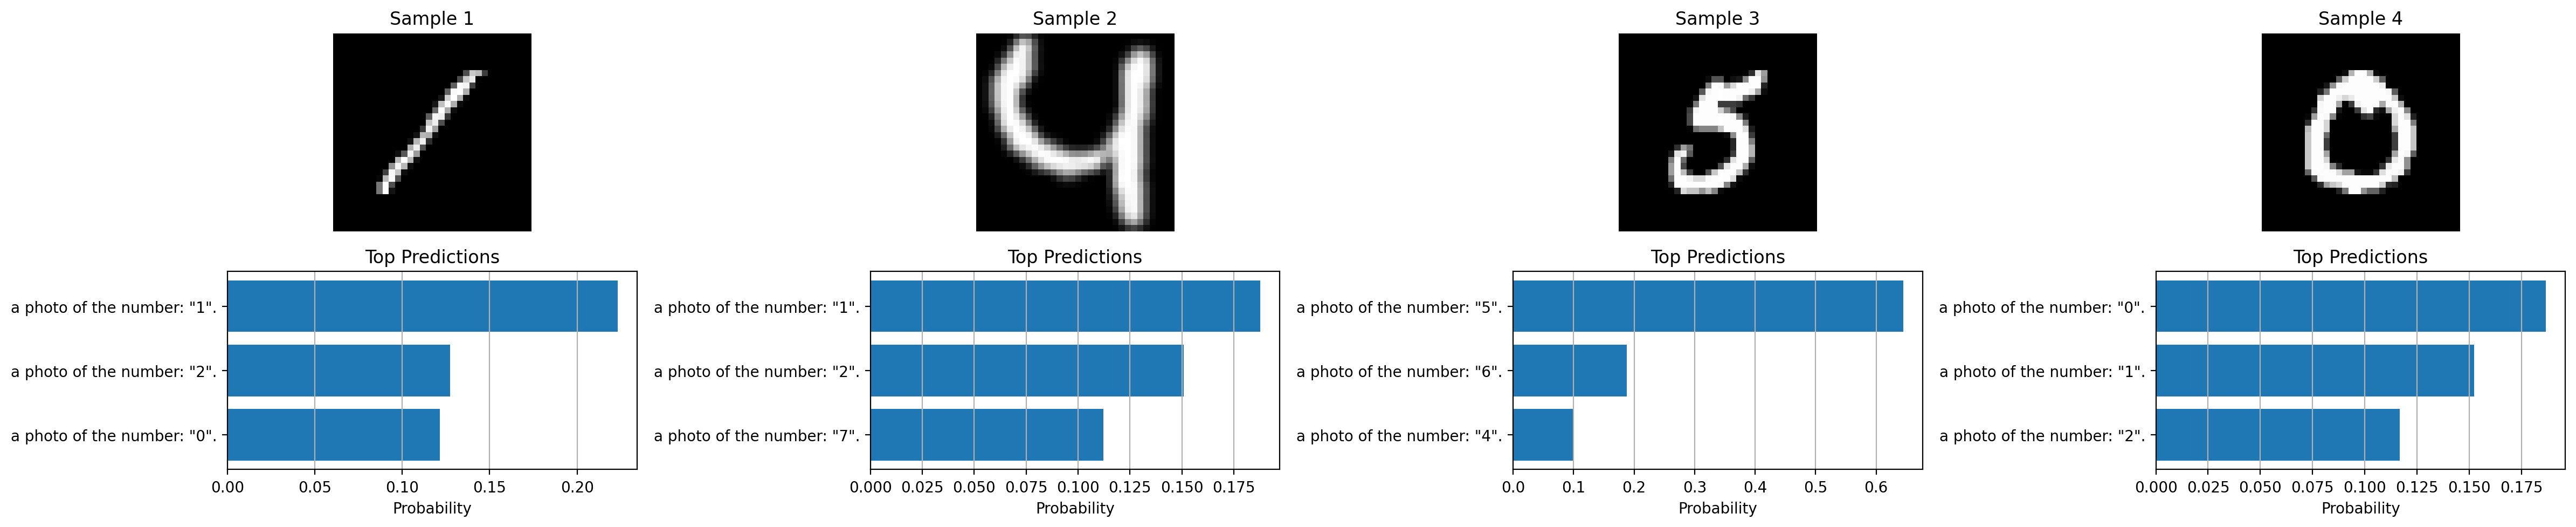

In [50]:
plot_prob_batch(sample_images[:4], sample_top_probs[:4], sample_top_labels[:4], labels, k=3)

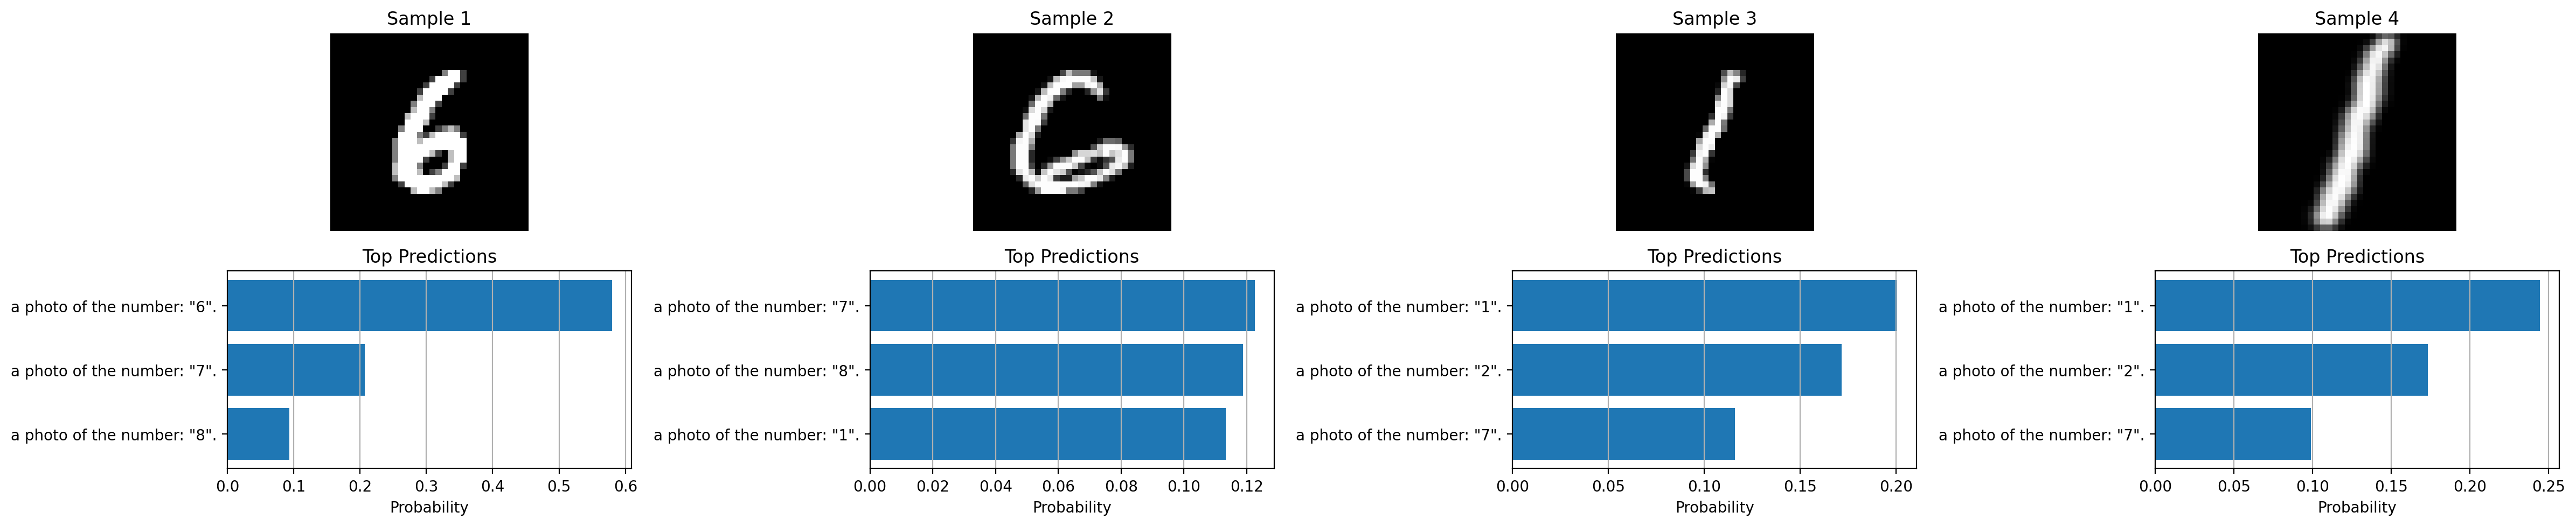

In [51]:
plot_prob_batch(sample_images[4:8], sample_top_probs[4:8], sample_top_labels[4:8], labels, k=3)